In [ ]:
#From the pyticles outputs (64 nc files corresponding to 101 days of particles released)
#We create 64 nc files that containt all the images neeeded for corresponding period

In [1]:
#Load packages

from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
from Modules import *
from Modules_gula import *

# Compute input variables

In [2]:
# Take a time start and a center (ic,jc) that correspond to the PAP station
# Compute ssh, temperature, vorticity, u and v field 
# at the corresponding time for 3 vertical layer (200 m, 500 m and 1000 m)
# All images are (520 x 520) spatial point resolution

def compute_variable(tstart,ic,jc):
    
    my_simul = 'apero'

    #parameters = my_simul + ' [1068,2068,117,1117,[1,100,1]] '+ format(date_plot_AC)
    str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-260,jc+260,ic-260,ic+260)
    parameters = my_simul +str_para+ format(tstart)
    simul = load(simul = parameters, floattype=np.float64)

    depth = [-200,-500,-1000]
    temp = var('temp',simul,depths=depth).data
    ssh = var('zeta',simul).data
    u = var('u',simul,depths=depth).data
    v = var('v',simul,depths=depth).data
    print(temp.shape)
    vrt = np.zeros(temp.shape)
    for i in range(len(depth)):
        vrt[:,:,i] =  tools.psi2rho(tools.get_vrt(u[:,:,i],v[:,:,i],simul.pm,simul.pn) / tools.rho2psi(simul.f))
        #vrt[:,:,i] =  (tools.get_vrt(u[:,:,i],v[:,:,i],simul.pm,simul.pn) / (simul.f))
        
    ##############################################################
    # Define horizontal coordinates (deg, km, or grid points)
    ########################################################

    coord = 'km'

    if coord=='deg':
        #using lon,lat
        lon = simul.x; lat = simul.y
        xlabel = 'lon'; ylabel = 'lat'
    elif coord=='km':
        # using km
        [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
        lon = (lon/np.mean(simul.pm)*1e-3).T
        lat = (lat/np.mean(simul.pn)*1e-3).T
        xlabel = 'km'; ylabel = 'km'
    elif coord=='points':
        # using grid points
        [lon,lat] = np.meshgrid(np.arange(simul.x.shape[0])+simul.coord[2],np.arange(simul.x.shape[1])+simul.coord[0])
        lon,lat = lon.T,lat.T
        xlabel = 'grid pts'; ylabel = 'grid pts'
        
    lon = lon - lon[int(lon.shape[0]/2),0]
    lat = lat - lat[0,int(lat.shape[1]/2)]
    
    return (vrt,temp,ssh,u,v)

# Loop to add the time dim

In [3]:
# Add a temporal dim
# For each given time start, we have 6 time step (10 days)

def compute_variable_time_dim(time_start):
    # define dt and number or sample for 1 month :
    dt = 20
    nb_dt = 6

    [ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')
    
    vrt,temp,ssh,u,v = compute_variable(time_start,ic,jc)
    vrt_t = np.zeros((vrt.shape[0],vrt.shape[1],vrt.shape[2],nb_dt))
    temp_t = np.zeros((temp.shape[0],temp.shape[1],temp.shape[2],nb_dt))
    ssh_t = np.zeros((ssh.shape[0],ssh.shape[1],nb_dt))
    u_t = np.zeros((u.shape[0],u.shape[1],u.shape[2],nb_dt))
    v_t = np.zeros((v.shape[0],v.shape[1],v.shape[2],nb_dt))
    

    for i in range(nb_dt):
            vrt_t[:,:,:,i],temp_t[:,:,:,i],ssh_t[:,:,i],u_t[:,:,:,i],v_t[:,:,:,i] = compute_variable(time_start+dt*i,ic,jc)

    return(vrt_t,temp_t,ssh_t,u_t,v_t)

# Create the nc file

In [6]:
# For one period, create a nc file containning all the images needed

def Create_nc_file(time_start):

    vrt,temp,ssh,u,v = compute_variable_time_dim(time_start)

    nc_name = 'inputs_date_{0:06}.nc.'.format(time_start)
    
    #creating the file
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/INPUTS/{0}'.format(nc_name),'w')

    #Dimensions used
    nc.createDimension('xdim', 520)
    nc.createDimension('ydim', 520)
    nc.createDimension('xdim_u', 519)
    nc.createDimension('ydim_v', 519)
    nc.createDimension('depth', 3)
    nc.createDimension('time', 6)

    #Variables used
    nc.createVariable('temperature', 'f4', ('xdim', 'ydim','depth','time'))
    nc.createVariable('vorticity', 'f4', ('xdim', 'ydim','depth','time'))
    nc.createVariable('u', 'f4', ('xdim_u', 'ydim','depth','time'))
    nc.createVariable('v', 'f4', ('xdim', 'ydim_v','depth','time'))
    nc.createVariable('ssh', 'f4', ('xdim', 'ydim','time'))
    
    nc.variables['temperature'][:] = temp
    nc.variables['vorticity'][:] = vrt
    nc.variables['u'][:] = u
    nc.variables['v'][:] = v
    nc.variables['ssh'][:] = ssh
    
    nc.close()


# Generate all the ncfile

In [7]:
# Create all 64 nc files
# Choose the folder

folder = '/home2/datawork/tpicard/Pyticles/OUTPUTS/'

for tpas in range(0,1,1):

    date2 = 101*tpas
    Create_nc_file(date2)

args (['apero', '[357,877,1308,1828,[1,100,1]]', '0'],)
args[0] ['apero', '[357,877,1308,1828,[1,100,1]]', '0']
len(args[0]) 3
time of simulation is: 0
file is  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
get domain [357,877,1308,1828,[1,100,1]] [357,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
[357, 877, 1308, 1828, array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 

# Validation of the data

In [4]:
time_start = 202
nc_name = 'inputs_date_{0:06}.nc.'.format(time_start)
nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/INPUTS/{0}'.format(nc_name),'r')

temperature = np.asfortranarray(nc.variables['temperature'])
vrt = np.asfortranarray(nc.variables['vorticity'])
u = np.asfortranarray(nc.variables['u'])
v = np.asfortranarray(nc.variables['v'])
ssh = np.asfortranarray(nc.variables['ssh'])

nc.close()

In [6]:
temperature.shape

(520, 520, 3, 6)

<ipython-input-7-491bb4473cd5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,temperature[:,:,0,0])


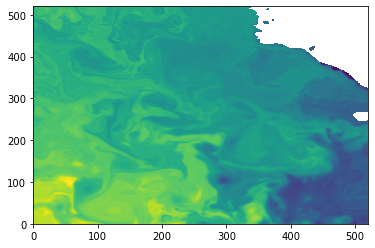

In [7]:
x = np.linspace(0,520,520)
y = np.linspace(0,520,520)
plt.pcolormesh(x,y,temperature[:,:,0,0])

# Spacial filter for inputs

In [65]:
# Feed we a nc file where 1 nc file = 101 days of simu
# Return inputs for every 36 patches during this periods

[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')

#ic_all_list = ic np.linspace(1520.5,1610.5,6)
#jc_all_list = jc - np.linspace(569.5,659.5,6)

ic_all_list = ic - np.linspace(1521,1611,6).astype(int) #WARNING BIAS OF 1km
jc_all_list = jc - np.linspace(570,660,6).astype(int)
    
def input_spacial_filter(ncfile,ic_all_list,jc_all_list):
    
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/INPUTS/{0}'.format(ncfile),'r')
    
    temperature = np.asfortranarray(nc.variables['temperature'])
    vrt = np.asfortranarray(nc.variables['vorticity'])
    u = np.asfortranarray(nc.variables['u'])
    v = np.asfortranarray(nc.variables['v'])
    ssh = np.asfortranarray(nc.variables['ssh'])
    
    nc.close()

    temperature_filtrer = np.zeros((400,400,3,6,36))
    vrt_filtrer = np.zeros((400,400,3,6,36))
    u_filtrer = np.zeros((400,400,3,6,36))
    v_filtrer = np.zeros((400,400,3,6,36))
    ssh_filtrer = np.zeros((400,400,6,36))
    i = 0
    
    for d_ic in ic_all_list:
        for d_jc in jc_all_list:
            temperature_filtrer[:,:,:,:,i] = temperature[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            vrt_filtrer[:,:,:,:,i] = vrt[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            u_filtrer[:,:,:,:,i] = u[59+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            v_filtrer[:,:,:,:,i] = v[60+d_ic:-60+d_ic,60+d_jc:-59+d_jc,:,:]
            ssh_filtrer[:,:,:,i] = ssh[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:]
            i = i+1
    return(temperature_filtrer,vrt_filtrer,u_filtrer,v_filtrer,ssh_filtrer)
        

# Visual test

<ipython-input-72-03be585ba98d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,temperature_filtrer[:,:,0,0,3])


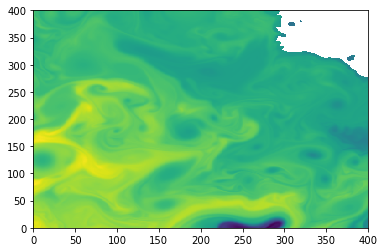

In [72]:
x = np.linspace(0,400,400)
y = np.linspace(0,400,400)
plt.pcolormesh(x,y,temperature_filtrer[:,:,0,0,3])